Program to see the behavior of different noise in parameter transfer and selective layer optimization for varying circuit depth of QAOA for Maxcut Problem (u3R graphs).

For circuit depth = 1, the first layer is optimizad after the parameter transfer because there is no further layers. But for multiple circuit depth, we are optimizing only the 2nd layer.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize
from scipy import linalg

from qiskit.quantum_info import Kraus
from qiskit_aer.noise import (
    NoiseModel,
    amplitude_damping_error,  # for T1 error
    phase_damping_error,  # for T2 error
    depolarizing_error,  # for Gate error
    pauli_error,  # for Phase and Bit flip noise
)

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


Program to return the expectation value of cost Hamiltonian with respect to the state prepared by the quantum circuit (ansatz)

In [425]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

Donor Graph G1, It's parameters will be optimized using p layers of QAOA then we obtain 2p optimized parameters. There optimized parameters will be transferred to the QAOA for the acceptor graph as initial parameters.

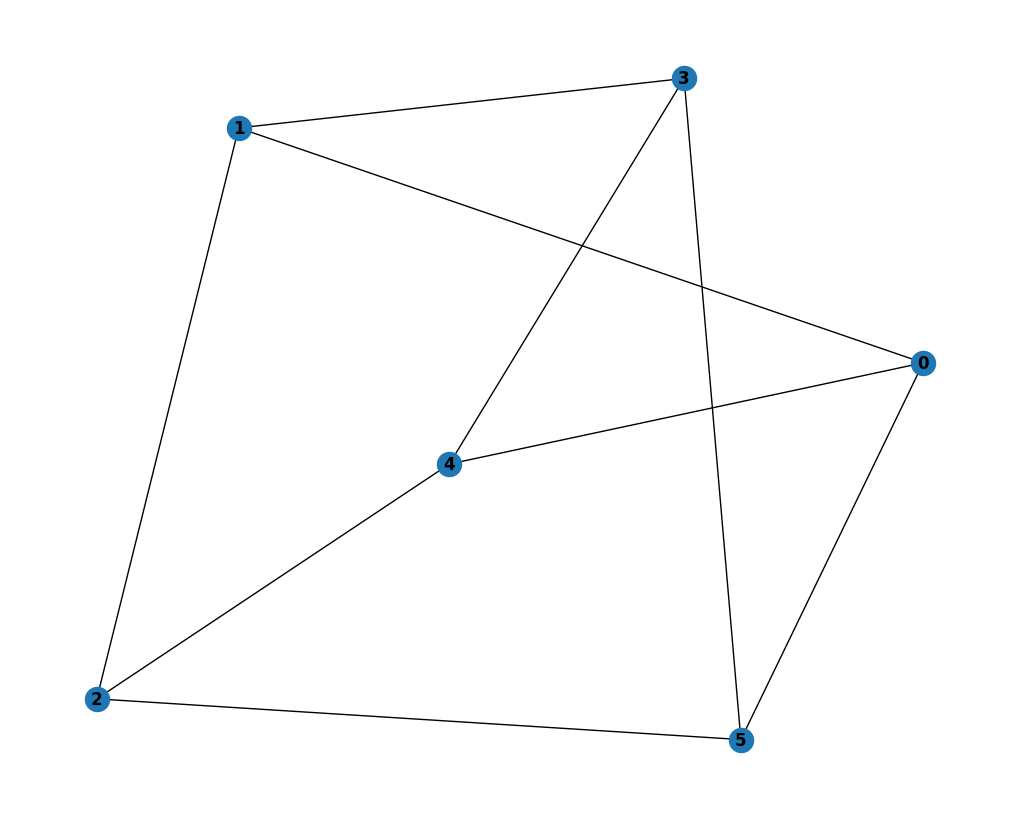

In [426]:
# make sure dxn is even for d-regular graph.
n1 = 6  # number of vertices
d = 3  #  d-regular graph
p = 5  # QAOA layers

plt.figure(figsize=(10,8))
# udR (unweghted d-regular) graph
G1 = nx.random_regular_graph(d ,n1)
for (u,v) in G1.edges():
    G1[u][v]['weight'] = 1.0

edges1 = G1.edges()
nx.draw(G1, with_labels=True, font_weight='bold')

# weight matrix
w1 = np.zeros([n1,n1])
for (u,v) in G1.edges():
    w1[u][v] = G1[u][v]['weight']
    w1[v][u] = G1[u][v]['weight']
#print(w1)
plt.savefig('donor graph.pdf', dpi=300, bbox_inches='tight')
plt.close
plt.show()


True Maxcut value of donor graph G1 calculated using brute force method.

In [427]:
# classical solution
sol1 = 0
for b in range(2**n1):
    x1 = [int(t) for t in reversed(list(bin(b)[2:].zfill(n1)))]
    Cut_value1 = 0
    for i in range(n1):
        for j in range(n1):
            Cut_value1 += w1[i][j]*x1[i]*(1-x1[j])
    if sol1 < Cut_value1:
        sol1 = Cut_value1
        xlist1 = x1

print(f"Classical solution: {sol1}")

Classical solution: 9.0


Converting classical Maxcut problem into Hamiltonian 

In [428]:
prob=Maxcut(w1)
qp = prob.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

cost_hamiltonian1, offset1 = qubo.to_ising()
print('offset:', offset1)
print(cost_hamiltonian1)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_4 - 2*x_0*x_5 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_2*x_4
  - 2*x_2*x_5 - 2*x_3*x_4 - 2*x_3*x_5 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5

Problem name: Max-cut

Minimize
  2*x_0*x_1 + 2*x_0*x_4 + 2*x_0*x_5 + 2*x_1*x_2 + 2*x_1*x_3 + 2*x_2*x_4
  + 2*x_2*x_5 + 2*x_3*x_4 + 2*x_3*x_5 - 3*x_0 - 3*x_1 - 3*x_2 - 3*x_3 - 3*x_4
  - 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5

offset: -4.5
SparsePauliOp(['IIIIZZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


Acceptor Graph which has more nodes than donor graph. It's QAOA will be selectively optimized after using the optimized parameters of donor graph as acceptor graph.

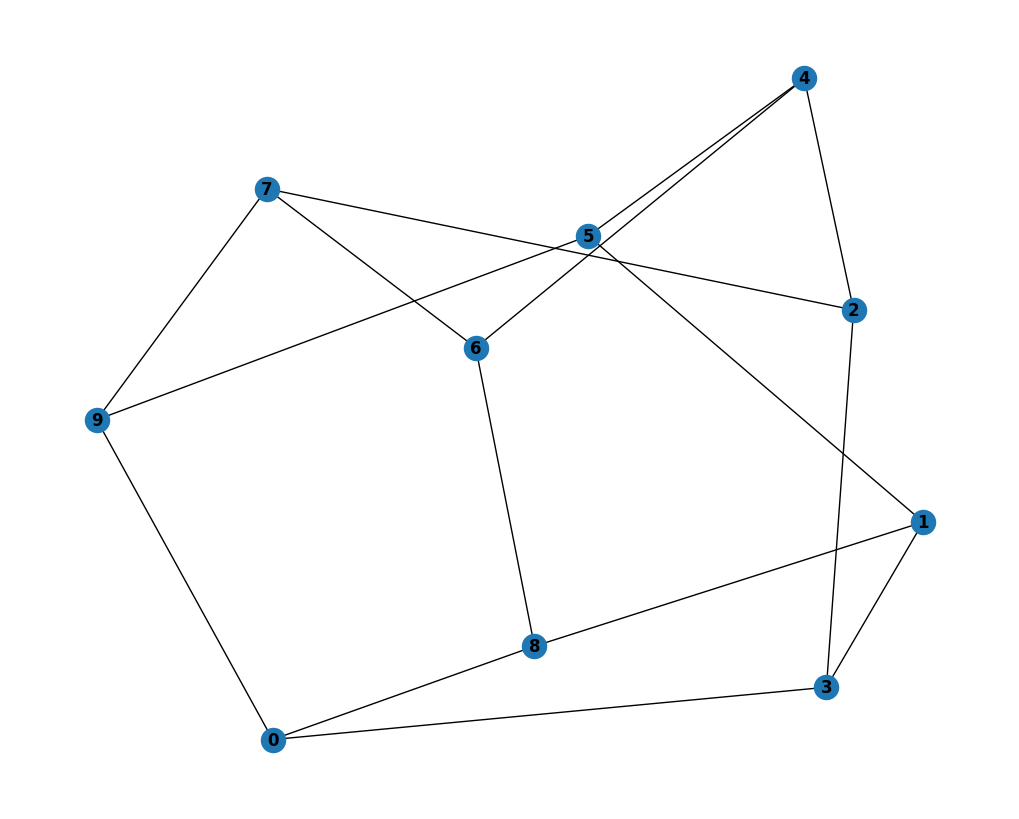

In [429]:
# make sure dxn is even for d-regular graph.
n2 = 10  # number of vertices

plt.figure(figsize=(10,8))
# udR (unweghted d-regular) graph
G2 = nx.random_regular_graph(d ,n2)
for (u,v) in G2.edges():
    G2[u][v]['weight'] = 1.0

edges = G2.edges()
nx.draw(G2, with_labels=True, font_weight='bold')

# weight matrix
w2 = np.zeros([n2,n2])
for (u,v) in G2.edges():
    w2[u][v] = G2[u][v]['weight']
    w2[v][u] = G2[u][v]['weight']

True Maxcut value of acceptor graph

In [430]:
# classical solution
sol2 = 0
for b in range(2**n2):
    x1 = [int(t) for t in reversed(list(bin(b)[2:].zfill(n2)))]
    Cut_value1 = 0
    for i in range(n2):
        for j in range(n2):
            Cut_value1 += w2[i][j]*x1[i]*(1-x1[j])
    if sol2 < Cut_value1:
        sol2 = Cut_value1
        xlist1 = x1

print(f"Classical solution: {sol2}")

Classical solution: 13.0


Converting Classical acceptor graph Maxcut problem into Hamiltonian

In [431]:
prob=Maxcut(w2)
qp = prob.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

cost_hamiltonian2, offset2 = qubo.to_ising()
print('offset: ',offset2)
print(cost_hamiltonian2)

Problem name: Max-cut

Maximize
  -2*x_0*x_3 - 2*x_0*x_8 - 2*x_0*x_9 - 2*x_1*x_3 - 2*x_1*x_5 - 2*x_1*x_8
  - 2*x_2*x_3 - 2*x_2*x_4 - 2*x_2*x_7 - 2*x_4*x_5 - 2*x_4*x_6 - 2*x_5*x_9
  - 2*x_6*x_7 - 2*x_6*x_8 - 2*x_7*x_9 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5 + 3*x_6 + 3*x_7 + 3*x_8 + 3*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

Problem name: Max-cut

Minimize
  2*x_0*x_3 + 2*x_0*x_8 + 2*x_0*x_9 + 2*x_1*x_3 + 2*x_1*x_5 + 2*x_1*x_8
  + 2*x_2*x_3 + 2*x_2*x_4 + 2*x_2*x_7 + 2*x_4*x_5 + 2*x_4*x_6 + 2*x_5*x_9
  + 2*x_6*x_7 + 2*x_6*x_8 + 2*x_7*x_9 - 3*x_0 - 3*x_1 - 3*x_2 - 3*x_3 - 3*x_4
  - 3*x_5 - 3*x_6 - 3*x_7 - 3*x_8 - 3*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

offset:  -7.5
SparsePauliOp(['IIIIIIZIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IIIIIIZIZI', 'IIIIZIIIZI', 'IZIIIIIIZI', 'IIIIIIZZII', 'IIIIIZIZII', 'IIZIIIIZII', 'IIIIZZIIII', 'IIIZIZIIII', 'ZIIIZIIIII', 'IIZZIII

Function which gives expectation value of cost Hamiltonian by varying parameters of only selectively optimizable layer.

In [432]:
def cost_func_estimator_selective(params, ansatz, tra_params, hamiltonian, estimator, m, tp):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    sel_par = tra_params.copy()
    sel_par[m] = params[0]
    sel_par[tp+m] = params[1]
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, sel_par)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

noise parameter

In [433]:
err = 1.5e-2

Defining matrices to store cost and fidelity for different noise

In [434]:
cost = np.zeros([7, p])
fid = np.zeros([7,p])

In [ ]:
for jj in range(1, p+1, 1):  # Different circuit depth in QAOA

    #--------------------------------------------------------------------
    # DONOR GRAPH

    # Initializing the parameters for our quanutum circuit 
    # using Trotterized Quantum Annealing Initialization method.
    init_params = np.zeros(2*jj)
    tt = 0.75
    for i in range(0, jj, 1):
        init_params[i] = (1.0-i/jj)*tt
        init_params[i+jj] = (i/jj)*tt

    # Preparing circuit for donor graph
    circuit1 = QAOAAnsatz(cost_operator=cost_hamiltonian1, reps=jj)
    circuit1.measure_all()

    #--------------------------------------------------------------------------------
    # Ideal Case for donor graph to get optimized parameters to transfer
    sim_ideal = AerSimulator()
    pm5 = generate_preset_pass_manager(optimization_level=3,backend=sim_ideal)
    candidate_circuit5 = pm5.run(circuit1)

    with Session(backend=sim_ideal) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        result5 = minimize(
            cost_func_estimator,
            init_params,
            args=(candidate_circuit5, cost_hamiltonian1, estimator),
            method="COBYLA",
            tol=1e-3,
        )
    
    # Transferring optimized parameters of donor graph into acceptor graph QAOA initial parameters
    tra_params = result5.x

    #--------------------------------------------------------------------------------
    # ACCEPTOR GRAPH
    
    # Preparing circuit for acceptor graph
    circuit = QAOAAnsatz(cost_operator=cost_hamiltonian2, reps=jj)
    circuit.measure_all()

    # Ideal Case
    sim_ideal = AerSimulator(method='density_matrix')
    pm5 = generate_preset_pass_manager(optimization_level=3,backend=sim_ideal)
    candidate_circuit3 = pm5.run(circuit)

    if jj == 1: # If cicuit depth is 1
        sl = 0  # optimize first layer
    else:  # is circuit depth is more than 1
        sl = 1  # optimize second layer

    # parameter of optimizable layer which will be optimized
    opt_par = [tra_params[sl], tra_params[jj+sl]]

    # QAOA run
    with Session(backend=sim_ideal) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        result3 = minimize(
            cost_func_estimator_selective,
            opt_par,
            args=(candidate_circuit3, tra_params, cost_hamiltonian2, estimator, sl, jj),
            method="COBYLA",
            tol=1e-3,
        )

    # updating parameters
    new_par = tra_params.copy()
    new_par[sl] = result3.x[0]
    new_par[jj+sl] = result3.x[1]
   
    # creating circuit with these updated parameters without measurement to get density matrix
    qaoa_circuit_ideal = candidate_circuit3.remove_final_measurements(inplace=False).assign_parameters(new_par)  # assigning optimum parameters
    qaoa_circuit_ideal.save_density_matrix(qubits=range(n2), label='rho_ideal')
    result_ideal= sim_ideal.run(transpile(qaoa_circuit_ideal, sim_ideal)).result()
    rho_ideal = result_ideal.data()['rho_ideal']  # superposition state\
    ideal_cost_val = offset2+np.real(np.trace(rho_ideal @ cost_hamiltonian2.to_matrix()))

    # storing fidelity and cost value for ideal case
    
    rho1 = linalg.sqrtm(rho_ideal)
    fidelity = np.trace(linalg.sqrtm(rho1.data@rho_ideal.data@rho1.data))
    fid[0][jj-1] = (np.abs(fidelity**2))
    cost[0][jj-1] = ideal_cost_val
    
    # 1-qubit Error
    err_phf = pauli_error([("Z", err), ("I", 1 - err)]) # phase-flip 
    err_bif = pauli_error([("X", err), ("I", 1 - err)]) # bit-flip
    err_amd = amplitude_damping_error(err) # amplitude-damping
    err_phd = phase_damping_error(err) # phase-damping
    err_dep_1q = depolarizing_error(err, num_qubits=1) # Depolarizing

    # 2-qubit Error
    err_phf_2q = err_phf.tensor(err_phf) # phase-flip 
    err_bif_2q = err_bif.tensor(err_bif) # bit-flip
    err_amd_2q = err_amd.tensor(err_amd) # amplitude-damping
    err_phd_2q = err_phd.tensor(err_phd) # phase-damping
    err_dep_2q = depolarizing_error(err, num_qubits=2) # Depolarizing

    # combining all 1-qubit errors
    err_all_1q = err_phf.compose(err_bif).compose(err_amd).compose(err_phd).compose(err_dep_1q)
    # Combining all 2-qubit errors
    err_all_2q = err_phf.compose(err_bif_2q).compose(err_amd_2q).compose(err_phd_2q).compose(err_dep_2q)

    #---------------------------------------------------------------------------------------------------
    # Phase Flip error
    noise_model_phf = NoiseModel()
    noise_model_phf.add_all_qubit_quantum_error(err_phf, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
    noise_model_phf.add_all_qubit_quantum_error(err_phf_2q, ['cx'])  # 2-qubit err[kk] gate specifications

    sim_all = AerSimulator(method='density_matrix', noise_model = noise_model_phf)
    pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
    candidate_circuit2 = pm1.run(circuit)

    with Session(backend=sim_all) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        opt_par = [tra_params[sl], tra_params[jj+sl]]
        result4 = minimize(
            cost_func_estimator_selective,
            opt_par,
            args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
            method="COBYLA",
            tol=1e-3,
        )

    new_par = tra_params.copy()
    new_par[sl] = result4.x[0]
    new_par[jj+sl] = result4.x[1]

    qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
    qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
    result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
    rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
    fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
    fid[1][jj-1] = np.abs(fidelity**2)  # Fidelity

    cost[1][jj-1] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))

    # -----------------------------------------------------------------------------------------------
    # Bit-flip error
    noise_model_bif = NoiseModel()
    noise_model_bif.add_all_qubit_quantum_error(err_bif, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
    noise_model_bif.add_all_qubit_quantum_error(err_bif_2q, ['cx'])  # 2-qubit err[kk] gate specifications

    sim_all = AerSimulator(method='density_matrix', noise_model = noise_model_bif)
    pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
    candidate_circuit2 = pm1.run(circuit)

    with Session(backend=sim_all) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        opt_par = [tra_params[sl], tra_params[jj+sl]]
        result4 = minimize(
            cost_func_estimator_selective,
            opt_par,
            args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
            method="COBYLA",
            tol=1e-3,
        )

    new_par = tra_params.copy()
    new_par[sl] = result4.x[0]
    new_par[jj+sl] = result4.x[1]

    qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
    qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
    result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
    rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
    fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
    fid[2][jj-1] = np.abs(fidelity**2)  # Fidelity
    cost[2][jj-1] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))

    # -----------------------------------------------------------------------------------------------
    # Phase damping error
    noise_model_phd = NoiseModel()
    noise_model_phd.add_all_qubit_quantum_error(err_phd, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
    noise_model_phd.add_all_qubit_quantum_error(err_phd_2q, ['cx'])  # 2-qubit err[kk] gate specifications

    sim_all = AerSimulator(method='density_matrix', noise_model = noise_model_phd)
    pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
    candidate_circuit2 = pm1.run(circuit)

    with Session(backend=sim_all) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        opt_par = [tra_params[sl], tra_params[jj+sl]]
        result4 = minimize(
            cost_func_estimator_selective,
            opt_par,
            args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
            method="COBYLA",
            tol=1e-3,
        )

    new_par = tra_params.copy()
    new_par[sl] = result4.x[0]
    new_par[jj+sl] = result4.x[1]

    qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
    qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
    result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
    rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
    fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
    fid[3][jj-1] = np.abs(fidelity**2)  # Fidelity
    cost[3][jj-1] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))

    # -------------------------------------------------------------------------------------------------
    # Amplitude Damping Error
    noise_model_amd = NoiseModel()
    noise_model_amd.add_all_qubit_quantum_error(err_amd, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
    noise_model_amd.add_all_qubit_quantum_error(err_amd_2q, ['cx'])  # 2-qubit err[kk] gate specifications

    sim_all = AerSimulator(method='density_matrix', noise_model = noise_model_amd)
    pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
    candidate_circuit2 = pm1.run(circuit)

    with Session(backend=sim_all) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        opt_par = [tra_params[sl], tra_params[jj+sl]]
        result4 = minimize(
            cost_func_estimator_selective,
            opt_par,
            args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
            method="COBYLA",
            tol=1e-3,
        )

    new_par = tra_params.copy()
    new_par[sl] = result4.x[0]
    new_par[jj+sl] = result4.x[1]

    qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
    qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
    result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
    rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
    fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
    fid[4][jj-1] = np.abs(fidelity**2)  # Fidelity
    cost[4][jj-1] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))

    # ---------------------------------------------------------------------------------------------
    # Depolarizing Noise
    noise_model_dep = NoiseModel()
    noise_model_dep.add_all_qubit_quantum_error(err_dep_1q, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
    noise_model_dep.add_all_qubit_quantum_error(err_dep_2q, ['cx'])  # 2-qubit err[kk] gate specifications

    sim_all = AerSimulator(method='density_matrix', noise_model = noise_model_dep)
    pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
    candidate_circuit2 = pm1.run(circuit)

    with Session(backend=sim_all) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        opt_par = [tra_params[sl], tra_params[jj+sl]]
        result4 = minimize(
            cost_func_estimator_selective,
            opt_par,
            args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
            method="COBYLA",
            tol=1e-3,
        )
    
    new_par = tra_params.copy()
    new_par[sl] = result4.x[0]
    new_par[jj+sl] = result4.x[1]

    qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
    qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
    result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
    rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
    fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
    fid[5][jj-1] = np.abs(fidelity**2)  # Fidelity
    cost[5][jj-1] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))

    # -----------------------------------------------------------------------------------------------
    # All Noise Combined
    # Noise Model
    noise_all = NoiseModel()
    noise_all.add_all_qubit_quantum_error(err_all_1q, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
    noise_all.add_all_qubit_quantum_error(err_all_2q, ['cx'])  # 2-qubit err[kk] gate specifications

    sim_all = AerSimulator(method='density_matrix', noise_model = noise_all)
    pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
    candidate_circuit2 = pm1.run(circuit)

    with Session(backend=sim_all) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        opt_par = [tra_params[sl], tra_params[jj+sl]]
        result4 = minimize(
            cost_func_estimator_selective,
            opt_par,
            args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
            method="COBYLA",
            tol=1e-3,
        )
    
    new_par = tra_params.copy()
    new_par[sl] = result4.x[0]
    new_par[jj+sl] = result4.x[1]

    qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
    qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
    result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
    rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
    fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
    fid[6][jj-1] = np.abs(fidelity**2)  # Fidelity
    cost[6][jj-1] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))
    
    print('iteration done :', jj)


iteration done : 1
iteration done : 2
iteration done : 3
iteration done : 4
iteration done : 5


In [436]:
from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

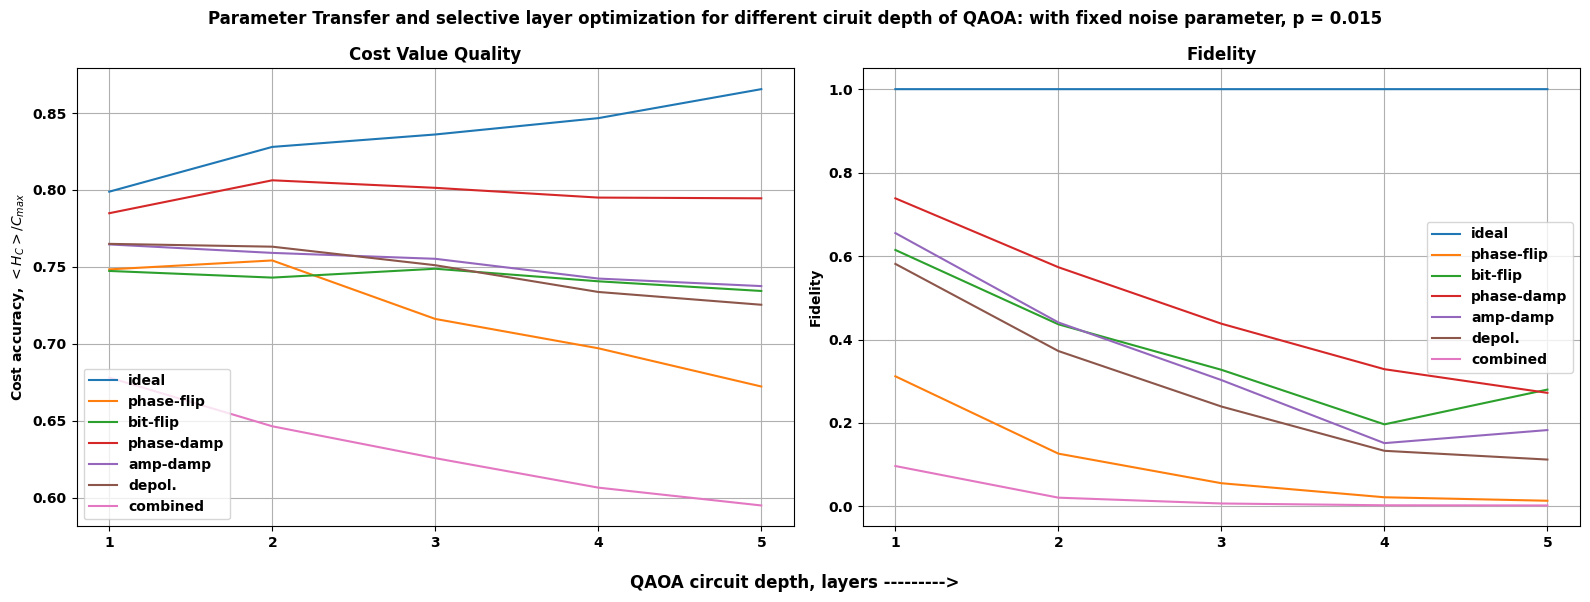

In [437]:
lab = ['ideal', 'phase-flip', 'bit-flip', 'phase-damp', 'amp-damp', 'depol.', 'combined']
fig, axs = plt.subplots(1,2, figsize=(16,6))
fig.supxlabel('QAOA circuit depth, layers --------->', fontweight='bold')
plt.subplots_adjust()
plt.suptitle('Parameter Transfer and selective layer optimization for different ciruit depth of QAOA' \
f': with fixed noise parameter, p = {err}', fontweight='bold')
plt.subplot(1,2,1)
for i in range(0, 7, 1):
    plt.plot(-cost[i]/sol2, label=f'{lab[i]}')
plt.grid()
plt.xticks([0,1,2,3,4], ['1', '2', '3', '4', '5'])
plt.ylabel('Cost accuracy, $<H_C>/C_{max}$', fontweight='bold')
plt.title('Cost Value Quality', fontweight='bold')
plt.legend()

plt.subplot(1,2,2)
for i in range(0, 7, 1):
    plt.plot(fid[i], label=f'{lab[i]}')
plt.title('Fidelity', fontweight='bold')
plt.ylabel('Fidelity', fontweight='bold')
plt.grid()
plt.xticks([0,1,2,3,4], ['1', '2', '3', '4', '5'])
plt.legend()
plt.tight_layout()
plt.savefig('fixed noise 1.5e-2 ptslo with increasing noise.pdf', dpi=300, bbox_inches='tight')
plt.show()